In [93]:
import torch
import numpy as np

# display CUDA devices available
torch.cuda.get_device_name(0)

# set device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [95]:
# load data

evals = np.load('../../data/evaluations.npy')
turns = np.load('../../data/turns.npy')
one_hot_boards = np.load('../../data/one_hot_boards.npy')

# reshape data to be 2D
evals = evals.reshape(-1, 1)
# normalize data to be / 100
EVAL_DIVISOR = 1000
evals = evals / EVAL_DIVISOR

# shuffle data
np.random.seed(0)
np.random.shuffle(evals)
np.random.seed(0)
np.random.shuffle(turns)
np.random.seed(0)
np.random.shuffle(one_hot_boards)

# split data into train and test
SPLIT_INDEX = int(len(evals) * 0.8)
train_evals = evals[:SPLIT_INDEX]
train_turns = turns[:SPLIT_INDEX]
train_boards = one_hot_boards[:SPLIT_INDEX]

test_evals = evals[SPLIT_INDEX:]
test_turns = turns[SPLIT_INDEX:]
test_boards = one_hot_boards[SPLIT_INDEX:]

# convert to tensors
train_evals = torch.from_numpy(train_evals).float()
train_turns = torch.from_numpy(train_turns).float()
train_boards = torch.from_numpy(train_boards).float()

test_evals = torch.from_numpy(test_evals).float()
test_turns = torch.from_numpy(test_turns).float()
test_boards = torch.from_numpy(test_boards).float()

# flatten boards and add turns 
train_boards = train_boards.view(train_boards.shape[0], -1)
train_boards = torch.cat((train_boards, train_turns), 1)

test_boards = test_boards.view(test_boards.shape[0], -1)
test_boards = torch.cat((test_boards, test_turns), 1)


# print 1 example
print(train_evals[6])
print(train_turns[0])
print(train_boards[0])


tensor([-0.3190])
tensor([1., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [98]:
# create model

# layers are 12*8*8 -> 512 -> 256+2 -> 128 -> 64 -> 1

class FeedForward(torch.nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(12*8*8 + 2, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 256 ) # 2 for turn
        self.fc4 = torch.nn.Linear(256, 128) # 2 for turn
        self.fc5 = torch.nn.Linear(128, 64)
        self.fc6 = torch.nn.Linear(64, 1)

        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.25)

    def forward(self, x):
        # reshape x to be 12*8*8
        # x = x.view(-1, 12*8*8)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc6(x)

        return x
    
    def predict(self, x):
        # reshape x to be 12*8*8
        # x = x.view(-1, 12*8*8)

        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        x = self.activation(x)
        x = self.fc6(x)

        return x

Epoch:  0 test:  379.2901337146759 train:  382.8018307685852
Epoch:  100 test:  367.4575686454773 train:  370.50607800483704
Epoch:  200 test:  357.3344051837921 train:  359.1744601726532
Epoch:  300 test:  350.58116912841797 train:  351.55874490737915
Epoch:  400 test:  334.13514494895935 train:  332.75431394577026
Epoch:  500 test:  309.68090891838074 train:  302.8070628643036
Epoch:  600 test:  282.82034397125244 train:  271.1573839187622
Epoch:  700 test:  257.16692209243774 train:  242.92196333408356
Epoch:  800 test:  235.50091683864594 train:  218.50620210170746
Epoch:  900 test:  218.8597470521927 train:  200.5321830511093
Epoch:  1000 test:  206.88724517822266 train:  187.43979930877686
Epoch:  1100 test:  195.76354324817657 train:  175.27766525745392
Epoch:  1200 test:  186.30459904670715 train:  164.80262577533722
Epoch:  1300 test:  175.8367419242859 train:  153.51013839244843
Epoch:  1400 test:  166.03371500968933 train:  142.72058010101318
Epoch:  1500 test:  156.83679282

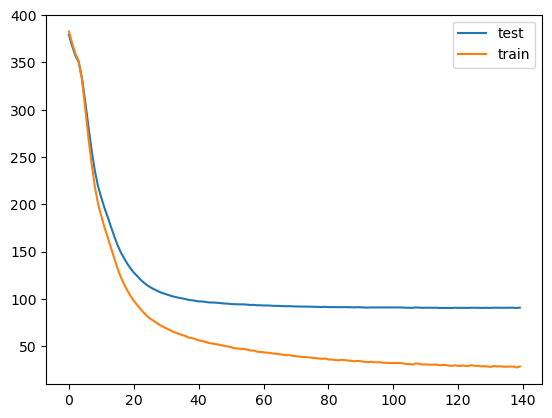

In [99]:
# model graphing code
test_loss_data = []
train_loss_data = []


# train model
loss = torch.nn.L1Loss()
model = FeedForward().to(device)

# hyperparameters
EPOCHS = 7000
BATCH_SIZE = 800
LEARNING_RATE = 15e-7

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# train
for epoch in range(EPOCHS):
  for i in range(0, len(train_evals), BATCH_SIZE):
    # get batch
    batch_evals = train_evals[i:i+BATCH_SIZE].to(device)
    batch_turns = train_turns[i:i+BATCH_SIZE].to(device)
    batch_boards = train_boards[i:i+BATCH_SIZE].to(device)

    # forward pass
    y_pred = model.forward(batch_boards)

    # calculate loss
    loss_val = loss(y_pred, batch_evals)

    # backward pass
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

  # print loss every 100 epochs
  if epoch % 100 == 0:
    # use test data to calculate loss
    y_pred = model.predict(test_boards.to(device))
    test_loss = loss(y_pred, test_evals.to(device)).item()*EVAL_DIVISOR

    # use train data to calculate loss
    y_pred = model.predict(train_boards.to(device))
    train_loss = loss(y_pred, train_evals.to(device)).item()*EVAL_DIVISOR
    print('Epoch: ', epoch, "test: ", test_loss, "train: ", train_loss)

    # save loss data
    test_loss_data.append(test_loss)
    train_loss_data.append(train_loss)


import matplotlib.pyplot as plt
# plot loss
plt.plot(test_loss_data, label='test')
plt.plot(train_loss_data, label='train')
plt.legend()
plt.show()



In [100]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [101]:
# load model
model = FeedForward().to(device)
model.load_state_dict(torch.load('model.pth'))

# test model
y_pred = model.predict(test_boards.to(device))
test_loss = loss(y_pred, test_evals.to(device)).item()*EVAL_DIVISOR
print('Test loss: ', test_loss)

Test loss:  90.45369923114777
